# Results Visualizations
> Ignorance is strength

In [ ]:
# hide
import blackhc.project.script

In [ ]:
import collections
import functools
import math
import os
import re
from collections import namedtuple
from dataclasses import dataclass
from typing import NamedTuple

import laaos
import pandas as pd
import seaborn as sns

In [ ]:
# https://codereview.stackexchange.com/questions/85311/transform-snake-case-to-camelcase
def camel_case_name(snake_case_name):
    return re.sub("_([a-z])", lambda match: match.group(1).upper(), snake_case_name)


__namedtuples = {}


def to_namedtuple(obj, name):
    type_name = "_" + camel_case_name(name)
    if isinstance(obj, dict):
        keys = tuple(obj.keys())
        if keys in __namedtuples:
            nt = __namedtuples[keys]
        else:
            nt = namedtuple(type_name, keys)
            __namedtuples[keys] = nt
        return nt(*(to_namedtuple(v, k) for k, v in obj.items()))
    if isinstance(obj, list):
        item_type_name = type_name + "Item"
        return [to_namedtuple(item, item_type_name) for item in obj]
    if isinstance(obj, set):
        item_type_name = type_name + "Item"
        return {to_namedtuple(item, item_type_name) for item in obj}
    if isinstance(obj, tuple):
        item_type_name = type_name + "Item"
        return tuple(to_namedtuple(item, item_type_name) for item in obj)

    return obj


def get_any(d: dict):
    return next(iter(d.values()))


def handle_map_funcs(func_kv, func_k, func_v, default=None):
    if func_kv:
        assert func_k is None and func_v is None

        def inner(kv):
            return func_kv(*kv)

    elif func_k:
        assert func_v is None

        def inner(kv):
            return func_k(kv[0]), kv[1]

    elif func_v:

        def inner(kv):
            return kv[0], func_v(kv[1])

    else:
        return default
    return inner


def handle_unary_funcs(pred_kv, pred_k, pred_v, default=None):
    if pred_kv:
        assert pred_k is None and pred_v is None

        def inner(kv):
            return pred_kv(*kv)

    elif pred_k:
        assert pred_v is None

        def inner(kv):
            return pred_k(kv[0])

    elif pred_v:

        def inner(kv):
            return pred_v(kv[1])

    else:
        return default
    return inner


def map_dict(d: dict, *, kv=None, k=None, v=None):
    inner = handle_map_funcs(kv, k, v)
    return dict(map(inner, d.items()))


def filter_dict(d: dict, *, kv=None, k=None, v=None):
    inner_pred = handle_unary_funcs(kv, k, v)
    return dict(filter(inner_pred, d.items()))


def sort_dict(d: dict, *, reverse=False, kv=None, k=None, v=None):
    inner_key = handle_unary_funcs(kv, k, v, default=lambda ikv: ikv[0])
    return dict(sorted(d.items(), key=inner_key, reverse=reverse))


def groupby_dict(d: dict, *, key_kv=None, key_k=None, key_v=None, agg=None):
    inner_key = handle_unary_funcs(key_kv, key_k, key_v)

    grouped_by = {}
    for kv in d.items():
        new_key = inner_key(kv)
        if new_key not in grouped_by:
            grouped_by[new_key] = {}
        key, value = kv
        grouped_by[new_key][key] = value

    if agg is not None:
        return map_dict(grouped_by, v=agg)

    return grouped_by

In [ ]:
def get_laaos_files(laaos_dir=None):
    if laaos_dir is None:
        laaos_dir = "./batchbald_redux/results"

    laaos_files = {}
    for root, dirs, files in os.walk(laaos_dir, topdown=False):
        for name in files:
            if not name.endswith(".py"):
                continue

            rel_path = os.path.join(root, name)
            result_name = rel_path[len(laaos_dir) :]
            abs_path = os.path.abspath(rel_path)
            laaos_files[result_name] = abs_path

    return laaos_files


def load_laaos_files(path=None, files=None, vanilla=False, tag=None, prefix=None):
    if files is None:
        files = get_laaos_files(path)

    stores = {}
    for name, path in files.items():

        def nan():
            pass

        store = laaos.safe_load(path, exposed_symbols=[nan])
        store["actual_name"] = name
        store["actual_path"] = path
        store["tag"] = tag

        key = f"{prefix}{name}" if prefix is not None else name
        stores[key] = store

    if vanilla:
        return stores
    else:
        return map_dict(stores, v=functools.partial(to_namedtuple, name="Result"))

In [ ]:
results = load_laaos_files("./results/softmax_bald_ablation")

In [ ]:
#results.update(load_laaos_files("./results/arxiv_draft_report/last_before_SA"))

In [ ]:
get_any(results)

_Result(timestamp=1624275991, cmdline=['/auto/users/andsch/github/active_learning_redux/batchbald_redux/experiment.py', '--id=17'], commit='d9226d45ccd4ca5537e05d267c84767957e12f5e', github_url='d9226d45ccd4ca5537e05d267c84767957e12f5e', experiment='/auto/users/andsch/github/active_learning_redux/batchbald_redux/experiment.py', job_id=17, worker_id=17, num_workers=90, config=_config(seed=132, acquisition_size=5, max_training_set=150, num_pool_samples=100, num_validation_samples=20, num_training_samples=1, num_patience_epochs=20, max_training_epochs=120, training_batch_size=64, device='cuda', validation_set_size=2048, initial_set_size=20, min_samples_per_epoch=1024, repeated_mnist_repetitions=2, add_dataset_noise=True, acquisition_function='batchbald_redux.acquisition_functions.TemperedBALD', train_eval_model='batchbald_redux.train_eval_model.TrainSelfDistillationEvalModel', model_optimizer_factory='batchbald_redux.models.MnistOptimizerFactory', acquisition_function_args=None, temperatu

In [ ]:
timestamps = pd.DataFrame.from_records(
    [dict(job_id=result.job_id, timestamp=result.timestamp) for result in results.values()]
)

In [ ]:
timestamps

,job_id,timestamp
0,17,1624275991
1,41,1624279397
2,57,1624280712
3,62,1624281734
4,8,1624286090
...,...,...
95,31,1624278194
96,2,1624291074
97,14,1624275943
98,16,1624275994


<AxesSubplot:xlabel='job_id', ylabel='timestamp'>

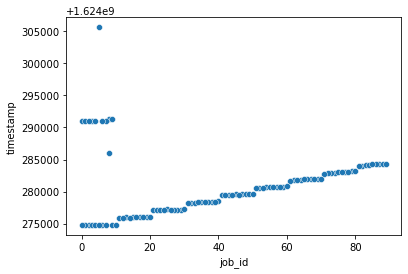

In [ ]:
grd = sns.scatterplot(data=timestamps, x="job_id", y="timestamp")
grd

In [ ]:
seed_acq_size_function_result = {}

for result in results.values():
    if not hasattr(result, "config"):
        print(file, "empty")
        continue

    seed_acq_size_function_result[
        (result.config.seed, result.config.acquisition_size, result.config.acquisition_function)
    ] = result

len(seed_acq_size_function_result), len(results)
# list(sorted(seed_acq_size_function_result.keys()))

(100, 100)

```
configs = [
            Experiment(
                seed=seed,
                acquisition_function=AcquisitionFunction.bald,
                acquisition_size=acquisition_size,
                num_pool_samples=num_pool_samples,
            )
            for seed in range(5)
            for acquisition_size in [5, 10, 20, 50]
            for num_pool_samples in [10, 20, 50, 100]
        ] + [
            Experiment(
                seed=seed,
                acquisition_function=AcquisitionFunction.random,
                acquisition_size=5,
                num_pool_samples=20,
            )
            for seed in range(20)
        ]
```

In [ ]:
experiment_data = []

for file, result in results.items():
    if not hasattr(result, "config"):
        print(file, "empty")
        continue

    config = result.config
    acquisition_size = config.acquisition_size
    if config.acquisition_function.startswith("batchbald_redux.acquisition_functions."):
        acquisition_function = config.acquisition_function[len("batchbald_redux.acquisition_functions.") :]
    elif config.acquisition_function.startswith("AcquisitionFunction."):
        acquisition_function = config.acquisition_function[len("AcquisitionFunction.") :]
    else:
        raise Exception(f"Unknown {config.acquisition_function}!")
        
    num_pool_samples = config.num_pool_samples
    temperature = config.temperature
    
    seed = config.seed

    acquisition_sizes = [acquisition_size]
    num_pool_samples = [num_pool_samples]
        
    if (acquisition_function not in ["random", "bald"] and result.timestamp < 1620000000) or acquisition_size != 5:
        continue
        
    for nps in num_pool_samples:
        for acquisition_size in acquisition_sizes:
            initial_set_size = len(result.initial_training_set_indices)
            
            if (
                initial_set_size
                + sum(1 if hasattr(step, "evaluation_metrics") or hasattr(step, "evalution_metrics") else 0 for step in result.active_learning_steps)
                * config.acquisition_size
                < 100
            ):
                print(len(result.active_learning_steps), file)
                continue

            for i, step in enumerate(result.active_learning_steps):
                if hasattr(step, "evaluation_metrics"):
                    evaluation_metrics = step.evaluation_metrics
                elif hasattr(step, "evalution_metrics"):
                    evaluation_metrics = step.evalution_metrics
                else:
                    break
                training_set_size = initial_set_size + i * config.acquisition_size
                accuracy = evaluation_metrics.accuracy

                experiment_data.append(
                    dict(
                        acquisition_function=acquisition_function,
                        acquisition_size=acquisition_size,
                        num_pool_samples=nps,
                        training_set_size=training_set_size,
                        accuracy=accuracy,
                        seed=seed,
                        temperature=temperature
                    )
                )

In [ ]:
df = pd.DataFrame.from_records(experiment_data)

In [ ]:
df

,acquisition_function,acquisition_size,num_pool_samples,training_set_size,accuracy,seed,temperature
0,TemperedBALD,5,100,20,0.6555,132,16.0
1,TemperedBALD,5,100,25,0.6862,132,16.0
2,TemperedBALD,5,100,30,0.7322,132,16.0
3,TemperedBALD,5,100,35,0.7363,132,16.0
4,TemperedBALD,5,100,40,0.7371,132,16.0
...,...,...,...,...,...,...,...
2695,TemperedBALD,5,100,130,0.8695,150,8.0
2696,TemperedBALD,5,100,135,0.8776,150,8.0
2697,TemperedBALD,5,100,140,0.8751,150,8.0
2698,TemperedBALD,5,100,145,0.8753,150,8.0


In [ ]:
df.acquisition_size.unique()

array([5])

In [ ]:
num_trials_by_acquisition_size_and_function = (
    df.query("training_set_size == 20").groupby("acquisition_size")["acquisition_function"].value_counts()
)
num_trials_by_acquisition_size_and_function.name = "num_trials"
print(num_trials_by_acquisition_size_and_function)

num_trials_by_acquisition_size_and_function = num_trials_by_acquisition_size_and_function.reset_index()

acquisition_size  acquisition_function
5                 SoftmaxBALD             45
                  TemperedBALD            45
                  BALD                     5
                  Random                   5
Name: num_trials, dtype: int64


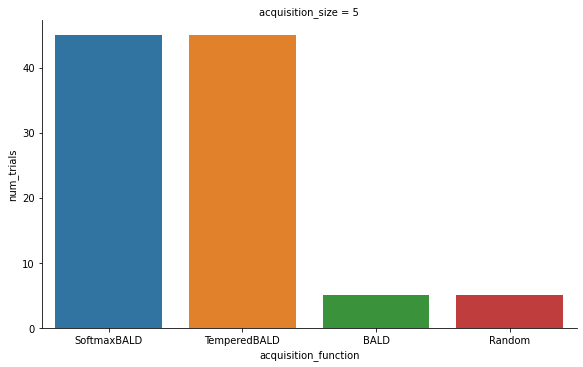

In [ ]:
grd = sns.catplot(
    data=num_trials_by_acquisition_size_and_function,
    kind="bar",
    y="num_trials",
    x="acquisition_function",
    col="acquisition_size",
    aspect=1.6,
)
grd.fig.patch.set_alpha(1)

In [ ]:
df["T"] = df.apply(axis=1, func=lambda row: f"T{row.temperature}" if row.acquisition_function != "Random" else "Tinf")

In [ ]:
T_sorted = [f"T{t}" for t in sorted(df["temperature"].unique())] + ["Tinf"]

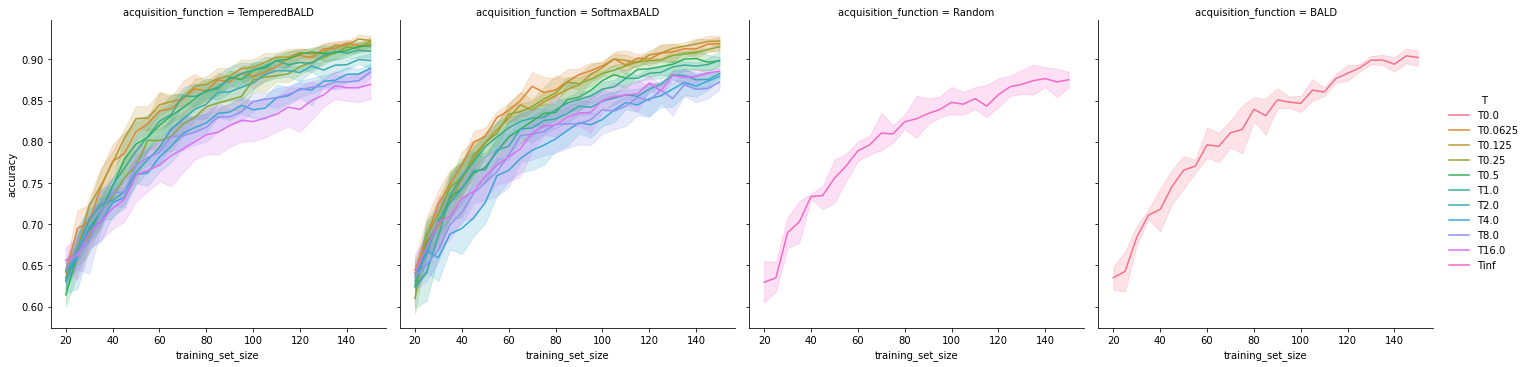

In [ ]:
grd = sns.relplot(
    x="training_set_size",
    y="accuracy",
    col="acquisition_function",
    hue="T",
    hue_order = T_sorted,
    data=df,
    kind="line",
    height=5,
)

grd.fig.patch.set_alpha(1)

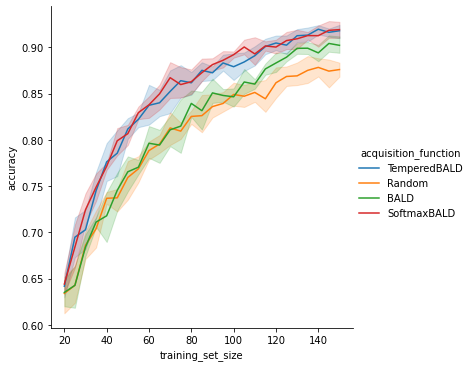

In [ ]:
grd = sns.relplot(
    x="training_set_size",
    y="accuracy",
    hue="acquisition_function",
    data=df[(df["T"]=="T0.0625") | (df["acquisition_function"].isin(["Random", "BALD"]))],
    kind="line",
    height=5,
)

grd.fig.patch.set_alpha(1)

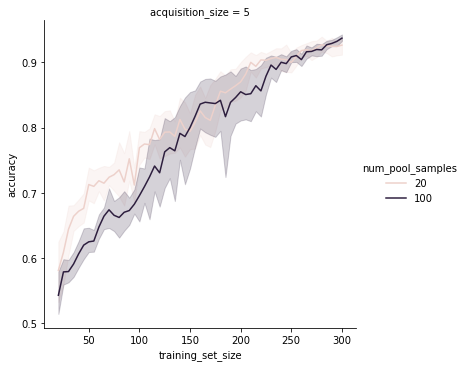

In [ ]:
grd = sns.relplot(
    x="training_set_size",
    y="accuracy",
    col="acquisition_size",
    hue="num_pool_samples",
    data=df[df.acquisition_function=="bald"],
    kind="line",
    height=5,
)

grd.fig.patch.set_alpha(1)

In [ ]:
import qgrid

df["max_accuracy"] = df.groupby(["seed", "acquisition_size", "acquisition_function", "num_pool_samples"]).accuracy.cummax()

df_max_accuracy = df.drop_duplicates(subset=["seed", "acquisition_size", "acquisition_function", "num_pool_samples", "max_accuracy"])
df_max_accuracy

,acquisition_function,acquisition_size,num_pool_samples,training_set_size,accuracy,seed,max_accuracy
0,bald,20,50,20,0.6365,27,0.6365
1,bald,20,50,40,0.6420,27,0.6420
2,bald,20,50,60,0.7008,27,0.7008
3,bald,20,50,80,0.7533,27,0.7533
4,bald,20,50,100,0.7995,27,0.7995
...,...,...,...,...,...,...,...
20390,bald,10,10,210,0.9386,21,0.9386
20393,bald,10,10,240,0.9401,21,0.9401
20396,bald,10,10,270,0.9426,21,0.9426
20397,bald,10,10,280,0.9524,21,0.9524


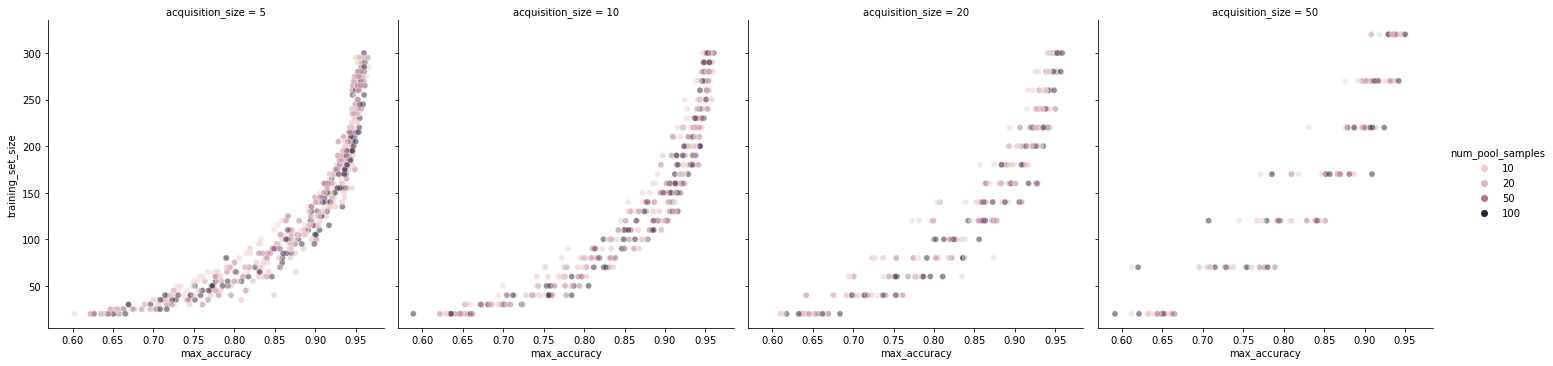

In [ ]:
grd = sns.relplot(
    y="training_set_size",
    x="max_accuracy",
    col="acquisition_size",
    hue="num_pool_samples",
    data=df_max_accuracy[df_max_accuracy.acquisition_function != "random"],
    kind="scatter",
    height=5,
    alpha=0.5,
)

grd.fig.patch.set_alpha(1)

In [ ]:
df2 = df[(df.accuracy >= 0.90) & (df.acquisition_function != "random")].groupby(["seed", "acquisition_size", "acquisition_function", "num_pool_samples"]).first()

In [ ]:
df3 = df2.groupby(["acquisition_size", "acquisition_function", "num_pool_samples"]).training_set_size.quantile([0.25, 0.5, 0.75])

In [ ]:
print(df3.unstack())

                                                         0.25   0.50   0.75
acquisition_size acquisition_function num_pool_samples                     
5                bald                 10                125.0  135.0  140.0
                                      20                115.0  120.0  125.0
                                      50                130.0  140.0  140.0
                                      100               125.0  125.0  130.0
10               bald                 10                140.0  160.0  210.0
                                      20                130.0  140.0  140.0
                                      50                130.0  160.0  160.0
                                      100               130.0  140.0  150.0
20               bald                 10                180.0  200.0  200.0
                                      20                180.0  200.0  200.0
                                      50                160.0  180.0  200.0
            